In [80]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import json

def read_jsonl_file(jsonl_path):
    with open(jsonl_path, "r") as f:
        for line in f:
            yield json.loads(line)

def get_silhouette_scores(X_train, k_range):
    sil = []
    for k in k_range:
        kmeans = KMeans(n_clusters=k).fit(X_train)
        labels = kmeans.labels_
        sil.append(silhouette_score(X_train, labels, metric='euclidean'))
    return sil


In [102]:
folder_path_0 = "gemma2_defects4j"
folder_path_1 = "gemma2_gbug-java"
folder_path_2 = "gemma2_humaneval"




def get_avg_silhouette_scores(folder, k, max_layers=24):

    results = []
    layer_idx = 0


    for folder in tqdm(folders):
        dirpath = os.path.join(folder_path, folder)
        if not os.path.isdir(dirpath):
            continue

        filenames = os.listdir(dirpath)

        if "layer" not in dirpath:
            continue
        # Initialize paths
        jsonl_path_diff = jsonl_path_safe = jsonl_path_vuln = None
        for filename in filenames:
            if filename == "feature_importance_diff.jsonl":
                jsonl_path_diff = os.path.join(dirpath, filename)
            elif filename == "feature_importance_safe.jsonl":
                jsonl_path_safe = os.path.join(dirpath, filename)
            elif filename == "feature_importance_vuln.jsonl":
                jsonl_path_vuln = os.path.join(dirpath, filename)

        # Skip if any required file is missing
        if not (jsonl_path_safe and jsonl_path_vuln):
            continue

        # Read and clean data
        safe_df = pd.DataFrame(read_jsonl_file(jsonl_path_safe))
        vuln_df = pd.DataFrame(read_jsonl_file(jsonl_path_vuln))

        safe_df.drop(columns=["labels", "model", "plot_type"], inplace=True)
        vuln_df.drop(columns=["labels", "model", "plot_type"], inplace=True)

        X_safe = safe_df["values"].tolist()
        X_vuln = vuln_df["values"].tolist()

        # Get scores
        sil_safe = get_silhouette_scores(X_safe, k_range)
        sil_vuln = get_silhouette_scores(X_vuln, k_range)


        results.append({
            "layer": layer_idx,
            "sil_safe": sil_safe,
            "sil_vuln": sil_vuln
        })

        layer_idx += 1
        if layer_idx >= max_layers:
            break

    return results


k_range = []

k_range.extend(list(np.arange(2, 10, 1)))
k_range.extend(list(np.arange(10, 101, 5)))
print(k_range)


results = []
for folder_path in tqdm([folder_path_0, folder_path_1, folder_path_2]):
    folders = os.listdir(folder_path)
    folders.sort(key=lambda x: int(x.split("layer")[1]))
    results.extend(get_avg_silhouette_scores(folder_path, k_range))



[np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(15), np.int64(20), np.int64(25), np.int64(30), np.int64(35), np.int64(40), np.int64(45), np.int64(50), np.int64(55), np.int64(60), np.int64(65), np.int64(70), np.int64(75), np.int64(80), np.int64(85), np.int64(90), np.int64(95), np.int64(100)]


  0%|          | 0/3 [00:04<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
len(results)

72

In [103]:
# with open("silhouette_scores_gemma2.json", "w") as f:
#     json.dump(results, f)

k_range = []

k_range.extend(list(np.arange(2, 10, 1)))
k_range.extend(list(np.arange(10, 101, 5)))
print(k_range)

with open("silhouette_scores_gemma2.json", "r") as f:
    results = json.load(f)

[np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(15), np.int64(20), np.int64(25), np.int64(30), np.int64(35), np.int64(40), np.int64(45), np.int64(50), np.int64(55), np.int64(60), np.int64(65), np.int64(70), np.int64(75), np.int64(80), np.int64(85), np.int64(90), np.int64(95), np.int64(100)]


In [100]:
for i in results:
    
    if len(i["sil_safe"]) != len(i["sil_vuln"]) != len(k_range):
        
        print(i)
        print("----")

    if len(i["sil_safe"]) != 27:
        print(i)
        print("ei")

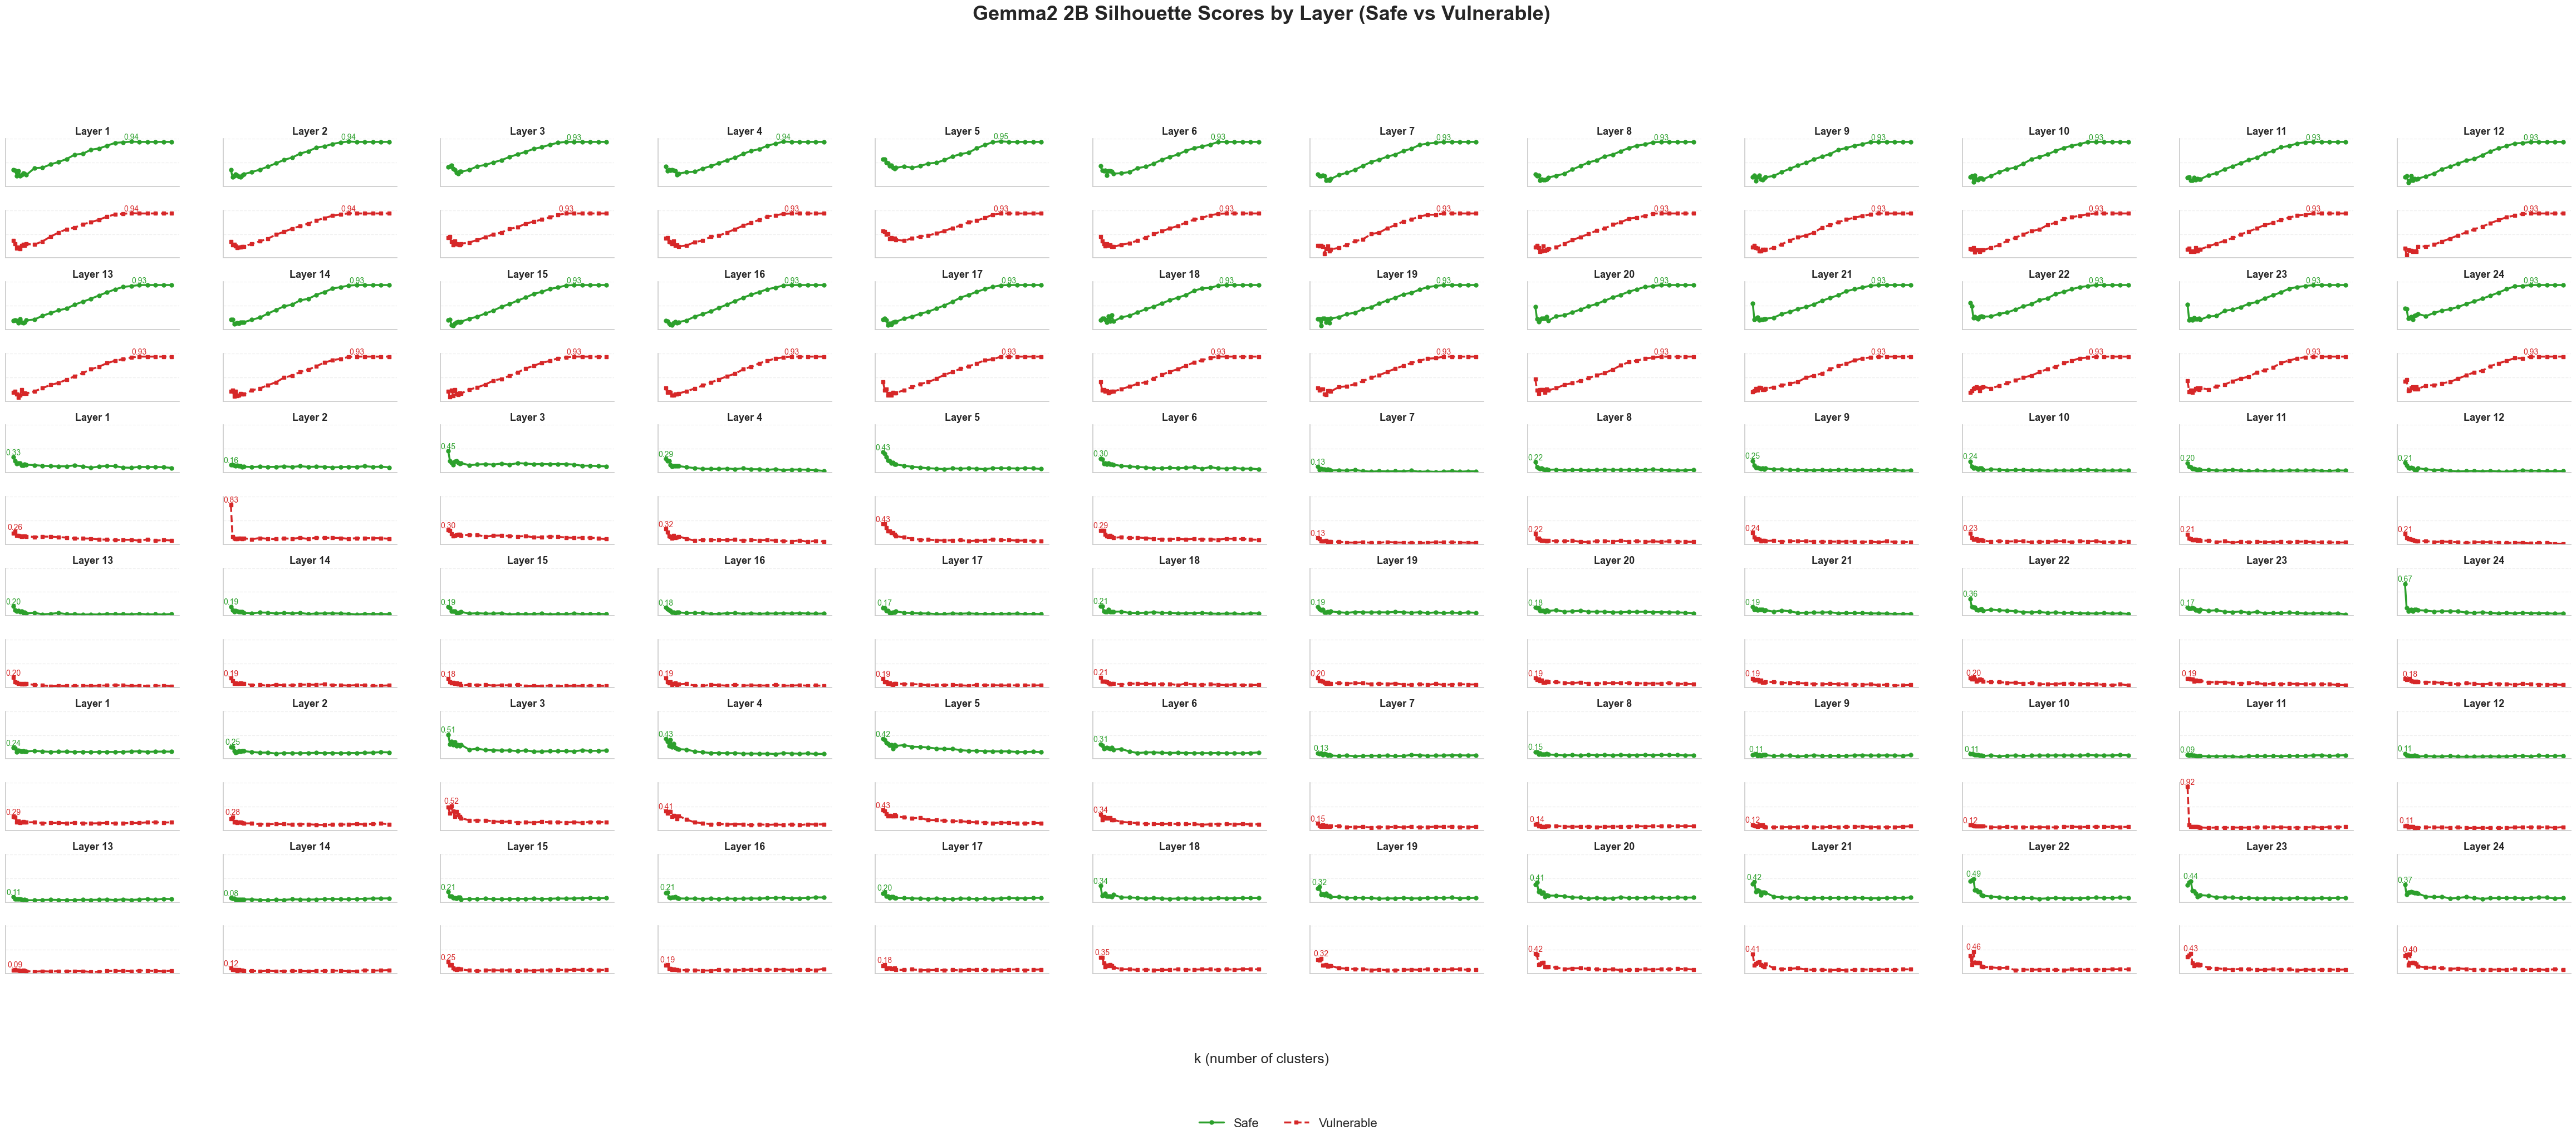

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Optional: set a consistent font
plt.rcParams["font.family"] = "Arial"

# Colors
safe_color = '#2ca02c'     # Greenish (Colorblind-friendly green)
vuln_color = '#d62728'     # Reddish (Colorblind-friendly red)
n_datasets = 3
fig, axes = plt.subplots(4 * n_datasets, 12, figsize=(48, 20), sharey=True)

legend_handles = []
legend_labels = []

for result_idx, result in enumerate(results):
    row = (result_idx // 12) * 2
    col = result_idx % 12

    ax_safe = axes[row, col]
    ax_vuln = axes[row + 1, col]

    # Plotting with markers
    safe_line, = ax_safe.plot(
        k_range, result["sil_safe"],
        color=safe_color, linewidth=2.5, linestyle='-',
        marker='o', markersize=5, label="Safe"
    )
    vuln_line, = ax_vuln.plot(
        k_range, result["sil_vuln"],
        color=vuln_color, linewidth=2.5, linestyle='--',
        marker='s', markersize=5, label="Vulnerable"
    )

    if result_idx == 0:
        legend_handles = [safe_line, vuln_line]
        legend_labels = ["Safe", "Vulnerable"]

    # Titles and limits
    ax_safe.set_title(f"Layer {result['layer'] + 1}", fontsize=13, weight='bold', pad=6)
    ax_safe.set_ylim(0, 1)
    ax_vuln.set_ylim(0, 1)

    # Grid and spine cleanup
    for ax in [ax_safe, ax_vuln]:
        ax.grid(True, linestyle='--', alpha=0.3)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

    # Tick cleanup
    ax_safe.set_xticks([])
    ax_vuln.set_xticks([])

    ax_safe.set_yticklabels([])
    ax_vuln.set_yticklabels([])

    # if row + 1 == axes.shape[0] - 1:
    #     ax_vuln.set_xticks(k_range)
    #     ax_vuln.set_xticklabels(k_range, fontsize=5, rotation=45)
    # else:
    ax_vuln.set_xticks([])

    # Add annotations for select layers
    max_k_safe = k_range[result["sil_safe"].index(max(result["sil_safe"]))]
    max_val_safe = max(result["sil_safe"])

    max_k_vuln = k_range[result["sil_vuln"].index(max(result["sil_vuln"]))]
    max_val_vuln = max(result["sil_vuln"])

    ax_safe.annotate(
        f'{max_val_safe:.2f}',
        xy=(max_k_safe, max_val_safe),
        xytext=(max_k_safe, max_val_safe + 0.05),
        fontsize=10,
        ha='center',
        color=safe_color,
        arrowprops=dict(facecolor=safe_color, arrowstyle='->', lw=1)
    )

    ax_vuln.annotate(
        f'{max_val_vuln:.2f}',
        xy=(max_k_vuln, max_val_vuln),
        xytext=(max_k_vuln, max_val_vuln + 0.05),
        fontsize=10,
        ha='center',
        color=vuln_color,
        arrowprops=dict(facecolor=vuln_color, arrowstyle='->', lw=1)
    )

# Global legend
fig.legend(
    handles=legend_handles, labels=legend_labels,
    loc='lower center', ncol=2, fontsize=16, frameon=False
)

# Super title
fig.suptitle(
    "Gemma2 2B Silhouette Scores by Layer (Safe vs Vulnerable)",
    fontsize=26, weight='bold', y=1.02
)

# Common X-axis label
fig.text(0.5, 0.07, 'k (number of clusters)', ha='center', fontsize=18)

# Layout adjustment
plt.subplots_adjust(
    left=0.03, right=0.99, top=0.90, bottom=0.15,
    wspace=0.25, hspace=0.5
)

plt.show()
